> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from personalization parameters (the decoder used in the co-adaptation algorithm). Thus, implement a basic ML model to link the decoder matrices back to the corresponding subject.  

- This NB is based off of NB107.  
- May want to log, save, and write all the decs from NBs 201/202.  
- Not sure whether it is worth testing on all conditions (e.g. to generate more training data for this adversarial model). I did so since there were so few instances of each class in the training data otherwise.  Well really each update doesn't matter only the user so maybe I didn't need to do that   
- Also should save the models from earlier NBs (102, 104, 106, 107) and see how they perform on this data
- Plot adversarial accuracy wrt each local iteration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *
from experiment_params import *
from fl_sim_classes import *

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#import warnings
#warnings.filterwarnings("ignore")

random.seed(a=1)

## Load Data

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

# For exclusion when plotting later on
bad_nodes = [1,3,13]

In [3]:
with open('Data\continuous_full_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, Ws_block1, _, _, _, _, _ = pickle.load(handle)

cond1b1_dict_list = [0]*num_participants
cond2b1_dict_list = [0]*num_participants
cond3b1_dict_list = [0]*num_participants
cond4b1_dict_list = [0]*num_participants
cond5b1_dict_list = [0]*num_participants
cond6b1_dict_list = [0]*num_participants
cond7b1_dict_list = [0]*num_participants
cond8b1_dict_list = [0]*num_participants
for idx in range(num_participants):
    b1_emg = emgs_block1[keys[idx]]
    b1_ref = refs_block1[keys[idx]]
    cond1b1_dict_list[idx] = {'training':b1_emg[0,:,:], 'labels':b1_ref[0,:,:]}
    cond2b1_dict_list[idx] = {'training':b1_emg[1,:,:], 'labels':b1_ref[1,:,:]}
    cond3b1_dict_list[idx] = {'training':b1_emg[2,:,:], 'labels':b1_ref[2,:,:]}
    cond4b1_dict_list[idx] = {'training':b1_emg[3,:,:], 'labels':b1_ref[3,:,:]}
    cond5b1_dict_list[idx] = {'training':b1_emg[4,:,:], 'labels':b1_ref[4,:,:]}
    cond6b1_dict_list[idx] = {'training':b1_emg[5,:,:], 'labels':b1_ref[5,:,:]}
    cond7b1_dict_list[idx] = {'training':b1_emg[6,:,:], 'labels':b1_ref[6,:,:]}
    cond8b1_dict_list[idx] = {'training':b1_emg[7,:,:], 'labels':b1_ref[7,:,:]}
    
    cond1b1_AllInitDecs_list = [Ws_block1[keys[i]][0, 0, :, :] for i in range(num_participants)]
    cond2b1_AllInitDecs_list = [Ws_block1[keys[i]][1, 0, :, :] for i in range(num_participants)]
    cond3b1_AllInitDecs_list = [Ws_block1[keys[i]][2, 0, :, :] for i in range(num_participants)]
    cond4b1_AllInitDecs_list = [Ws_block1[keys[i]][3, 0, :, :] for i in range(num_participants)]
    cond5b1_AllInitDecs_list = [Ws_block1[keys[i]][4, 0, :, :] for i in range(num_participants)]
    cond6b1_AllInitDecs_list = [Ws_block1[keys[i]][5, 0, :, :] for i in range(num_participants)]
    cond7b1_AllInitDecs_list = [Ws_block1[keys[i]][6, 0, :, :] for i in range(num_participants)]
    cond8b1_AllInitDecs_list = [Ws_block1[keys[i]][7, 0, :, :] for i in range(num_participants)]


## No-FL Case

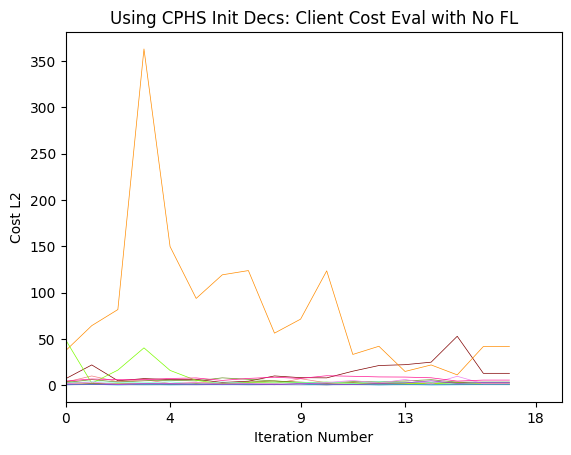

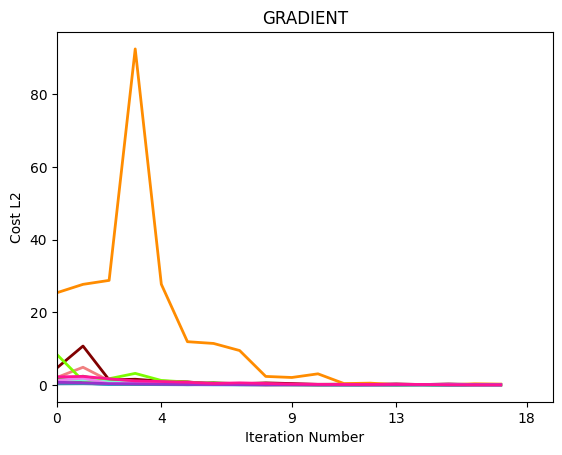

In [4]:
users_c1 = [Client(i, cond1b1_AllInitDecs_list[i], 'FullScipyMinStep', cond1b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_c1 = Server(-1, D_0, 'NoFL', users_c1, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_c1.execute_FL_loop()
    
condensed_external_plotting(users_c1, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')
condensed_external_plotting(users_c1, 'local', plot_gradient=True, dim_reduc_factor=1, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

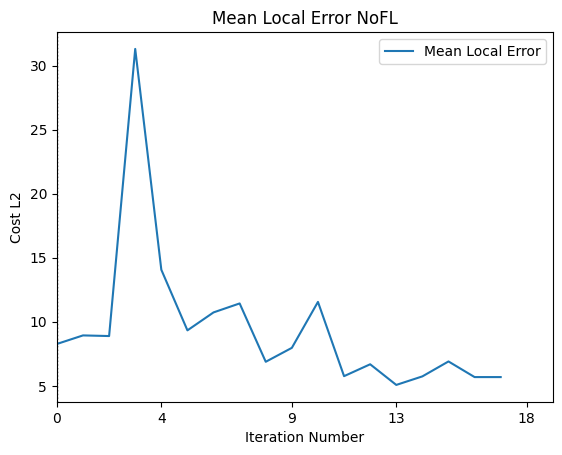

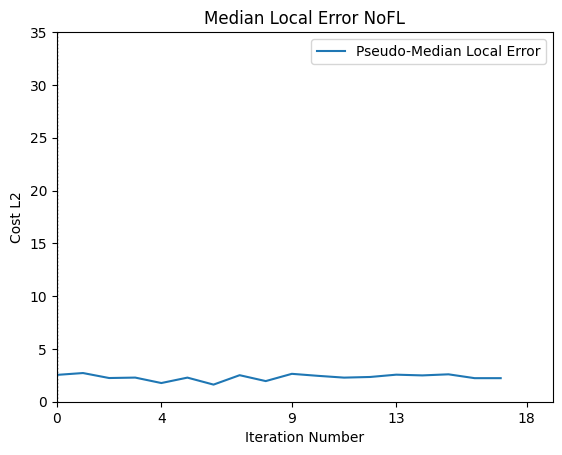

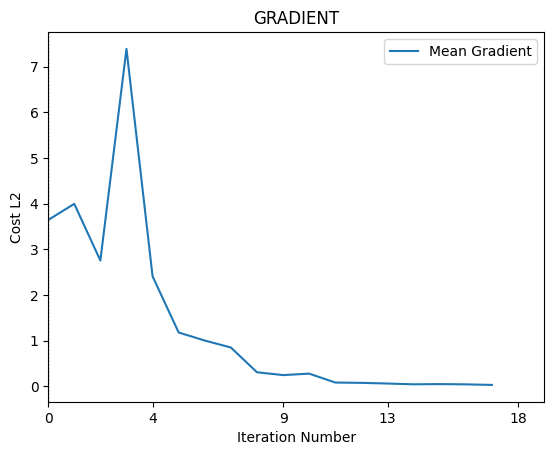

In [5]:
users1, all_dfs1, all_vecs1 = central_tendency_plotting([users_c1], global_error=False, dim_reduc_factor=1, custom_title='Mean Local Error NoFL')
users2, all_dfs2, all_vecs2 = central_tendency_plotting([users_c1], ylim_max=35, global_error=False, plot_mean=False, plot_median=True, dim_reduc_factor=1, custom_title='Median Local Error NoFL')
users3, all_dfs3, all_vecs3 = central_tendency_plotting([users_c1], plot_gradient=True, dim_reduc_factor=1, local_error=False, global_error=False, custom_title='GRADIENT')

In [6]:
users_c2 = [Client(i, cond2b1_AllInitDecs_list[i], 'FullScipyMinStep', cond2b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=2, delay_scaling=0) for i in range(14)]
global_c2 = Server(-1, D_0, 'NoFL', users_c2, PCA_comps=64)

users_c3 = [Client(i, cond3b1_AllInitDecs_list[i], 'FullScipyMinStep', cond3b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=3, delay_scaling=0) for i in range(14)]
global_c3 = Server(-1, D_0, 'NoFL', users_c3, PCA_comps=64)

users_c4 = [Client(i, cond4b1_AllInitDecs_list[i], 'FullScipyMinStep', cond4b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=4, delay_scaling=0) for i in range(14)]
global_c4 = Server(-1, D_0, 'NoFL', users_c4, PCA_comps=64)

users_c5 = [Client(i, cond5b1_AllInitDecs_list[i], 'FullScipyMinStep', cond5b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=5, delay_scaling=0) for i in range(14)]
global_c5 = Server(-1, D_0, 'NoFL', users_c5, PCA_comps=64)

users_c6 = [Client(i, cond6b1_AllInitDecs_list[i], 'FullScipyMinStep', cond6b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=6, delay_scaling=0) for i in range(14)]
global_c6 = Server(-1, D_0, 'NoFL', users_c6, PCA_comps=64)

users_c7 = [Client(i, cond7b1_AllInitDecs_list[i], 'FullScipyMinStep', cond7b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=7, delay_scaling=0) for i in range(14)]
global_c7 = Server(-1, D_0, 'NoFL', users_c7, PCA_comps=64)

users_c8 = [Client(i, cond8b1_AllInitDecs_list[i], 'FullScipyMinStep', cond8b1_dict_list[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, condition_number=8, delay_scaling=0) for i in range(14)]
global_c8 = Server(-1, D_0, 'NoFL', users_c8, PCA_comps=64)

num_updates_left = 19
for i in range(num_updates_left):
    global_c2.execute_FL_loop()
    global_c3.execute_FL_loop()
    global_c4.execute_FL_loop()
    global_c5.execute_FL_loop()
    global_c6.execute_FL_loop()
    global_c7.execute_FL_loop()
    global_c8.execute_FL_loop()

In [7]:
t0 = time.time()

dec_flattened1 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened2 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened3 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened4 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened5 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened6 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened7 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
dec_flattened8 = pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec'])
for key_idx, key in enumerate(keys):
    for update_number, update_idx in enumerate(update_ix):
        dec_flattened1.loc[len(dec_flattened1)] = [key, update_number, np.ravel(users_c1[key_idx].dec_log[update_number])]
        dec_flattened2.loc[len(dec_flattened2)] = [key, update_number, np.ravel(users_c2[key_idx].dec_log[update_number])]
        dec_flattened3.loc[len(dec_flattened3)] = [key, update_number, np.ravel(users_c3[key_idx].dec_log[update_number])]
        dec_flattened4.loc[len(dec_flattened4)] = [key, update_number, np.ravel(users_c4[key_idx].dec_log[update_number])]
        dec_flattened5.loc[len(dec_flattened5)] = [key, update_number, np.ravel(users_c5[key_idx].dec_log[update_number])]
        dec_flattened6.loc[len(dec_flattened6)] = [key, update_number, np.ravel(users_c6[key_idx].dec_log[update_number])]
        dec_flattened7.loc[len(dec_flattened7)] = [key, update_number, np.ravel(users_c7[key_idx].dec_log[update_number])]
        dec_flattened8.loc[len(dec_flattened8)] = [key, update_number, np.ravel(users_c8[key_idx].dec_log[update_number])]        
        
t1 = time.time()
total = t1-t0  
print(total)

5.241248607635498


In [8]:
# Concat all the dfs into a single training input dataframe
dec_flattened = pd.concat([dec_flattened1, dec_flattened2, dec_flattened3, dec_flattened4, dec_flattened5, dec_flattened6, dec_flattened7, dec_flattened8], ignore_index=True, axis=0)

# Make each ele its own cell
expanded_dec_df = dec_flattened.join(dec_flattened['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
print(expanded_dec_df.shape)
expanded_dec_df.head()

(2128, 130)


,Subject,Update Number,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,METACPHS_S106,0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,0.001421,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
1,METACPHS_S106,1,0.001243,0.002463,0.000509,0.006686,0.003009,0.000508,0.001013,-0.000711,...,0.003395,0.005837,0.005295,0.000999,0.001312,0.005053,0.008816,0.007758,0.006377,0.000240
2,METACPHS_S106,2,-0.000372,0.003810,-0.000075,0.005709,0.000862,-0.000247,-0.004618,-0.004766,...,0.001921,0.004090,0.003355,0.000977,0.002347,0.004636,0.005648,0.002985,0.001597,-0.003138
3,METACPHS_S106,3,0.001009,0.002855,-0.000121,0.005214,-0.002227,-0.003420,0.000007,-0.011986,...,-0.000223,0.003248,0.003910,0.002329,0.003220,0.004468,0.007297,0.001446,0.004493,-0.006419
4,METACPHS_S106,4,-0.000174,0.001306,-0.001158,0.004879,-0.001811,-0.005817,-0.001812,-0.010339,...,0.002242,0.000138,0.000030,0.001989,0.002812,0.004116,0.007054,0.003373,0.004395,-0.007981


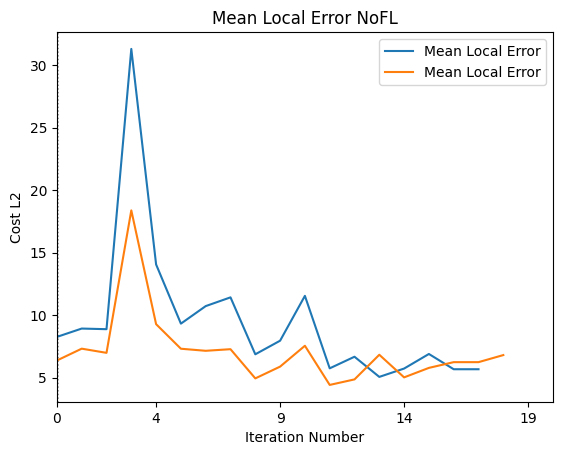

In [9]:
two_users, two_dfs, two_vecs = central_tendency_plotting([users_c1, users_c2], global_error=False, dim_reduc_factor=1, custom_title='Mean Local Error NoFL')

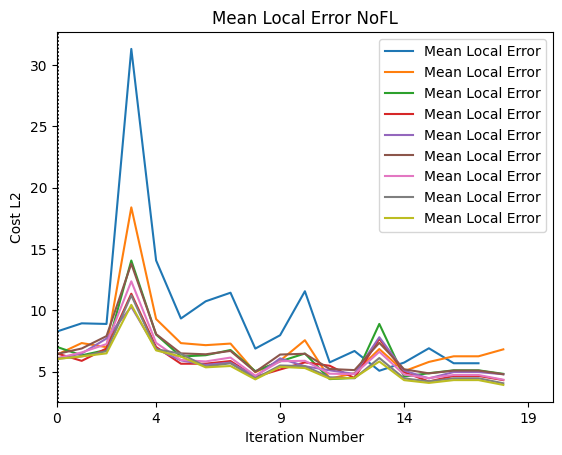

In [10]:
all_users, all_dfs, all_vecs = central_tendency_plotting([users_c1, users_c2, users_c3, users_c4, users_c5, users_c1, users_c6, users_c7, users_c8], global_error=False, dim_reduc_factor=1, custom_title='Mean Local Error NoFL')


In [11]:
assert(np.sum(expanded_dec_df.isnull().values)==0)

# Adversarial Modeling

In [12]:
#my_models = [LogisticRegression(), KNeighborsClassifier(), GradientBoostingClassifier()]
my_models = [LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [13]:
def make_all_update_models(flattened_input_df, n_start_stop=(0, 18), num_kfolds=5, stratification=False, my_metrics_columns=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds'], my_models_list=[LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], make_df=True, full_test_df=pd.DataFrame()):

    if make_df:
        full_test_df = pd.DataFrame(columns=my_metrics_columns)

    if n_start_stop[1]>=17:
        n_stop=16
    else:
        n_stop = n_start_stop[1]
    for i in range(n_start_stop[0], n_stop+1):
        print(f"Round i={i} of stop={n_start_stop[1]}")
        ith_df, ith_test_df = nth_decoder_model(flattened_input_df, i, my_models_list, stratification=stratification, cv=num_kfolds, test=True)

        full_test_df = pd.concat((full_test_df, ith_test_df))

    full_test_df.drop('K Folds', axis=1, inplace=True)
    full_test_df.drop('One Off Acc', axis=1, inplace=True)
    full_test_df.drop('CV Acc', axis=1, inplace=True)

    return full_test_df

In [14]:
demo_stratify=False
if demo_stratify:
    flat_dec_expanded_df = expanded_dec_df
    n=1

    non_nth_update_idxs = flat_dec_expanded_df[~(flat_dec_expanded_df['Update Number'] == n)].index
    dec_df = flat_dec_expanded_df.drop(non_nth_update_idxs)

    dec_labels_df = pd.DataFrame(dec_df['Subject'].map(key_to_num))
    dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)

    print(dec_df.shape)
    display(dec_df.head())

    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(dec_df, dec_labels_df)
    print(y_train.value_counts())

    from sklearn.model_selection import train_test_split
    X_train2, X_test2, y_train2, y_test2 = train_test_split(dec_df, dec_labels_df,
                                                        stratify=dec_labels_df, 
                                                        test_size=0.25)
    print(y_train2.value_counts())

In [15]:
full_test_df = make_all_update_models(expanded_dec_df, stratification=True)
print(full_test_df.shape)
full_test_df.head(8)

Round i=0 of stop=18
0
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=1 of stop=18
1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=2 of stop=18
2
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=3 of stop=18
3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=4 of stop=18
4
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=5 of stop=18
5
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=6 of stop=18
6
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=7 of stop=18
7
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=8 of stop=18
8
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=9 of stop=18
9
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=10 of stop=18
10
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=11 of stop=18
11
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=12 of stop=18
12
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=13 of stop=18
13
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=14 of stop=18
14
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=15 of stop=18
15
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=16 of stop=18
16
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


(119, 3)


,Algorithm,Test Acc,N
0,LogisticRegression(),17.647,0
0,KNeighborsClassifier(),50.0,0
0,GaussianNB(),91.176,0
0,LinearSVC(),17.647,0
0,SGDClassifier(),52.941,0
0,DecisionTreeClassifier(),100.0,0
0,GradientBoostingClassifier(),100.0,0
0,LogisticRegression(),11.765,1


## Plot Accuracy As a Func of N

In [16]:
lr_df = full_test_df[full_test_df['Algorithm']=='LogisticRegression()']
knn_df = full_test_df[full_test_df['Algorithm']=='KNeighborsClassifier()']
svc_df = full_test_df[full_test_df['Algorithm']=='LinearSVC()']
sgd_df = full_test_df[full_test_df['Algorithm']=='SGDClassifier()']
dt_df = full_test_df[full_test_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = full_test_df[full_test_df['Algorithm']=='GradientBoostingClassifier()']

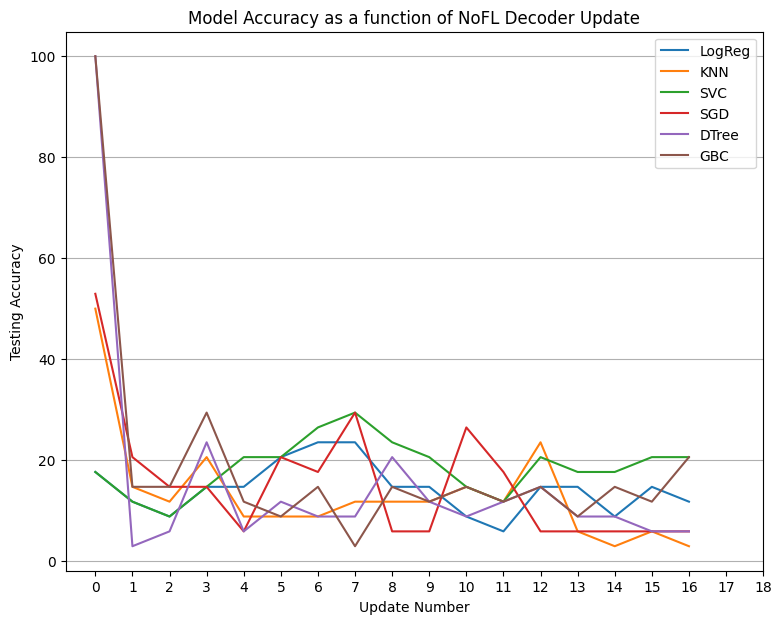

In [17]:
skip_block = 0
col_num = 1
my_x_updates = list(range(17))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[skip_block:, col_num], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[skip_block:, col_num], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[skip_block:, col_num], label='SVC')
plt.plot(my_x_updates, sgd_df.iloc[skip_block:, col_num], label='SGD')
plt.plot(my_x_updates, dt_df.iloc[skip_block:, col_num], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[skip_block:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

This one probably didn't do well since it has so little data to train on.  Each participant literally has like 6 examples total.

## 1 Scipy Step (FL)

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 0, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 0, 50)

(Current Local Round, Current Local Update)
(67, 12)
(68, 12)
(72, 12)
(70, 12)
(93, 13)
(78, 13)
(79, 13)
(71, 12)
(62, 12)
(63, 12)
(63, 12)
(71, 12)
(75, 13)
(68, 12)


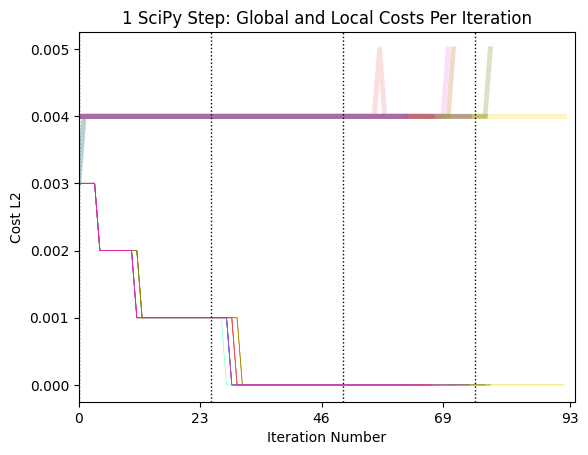

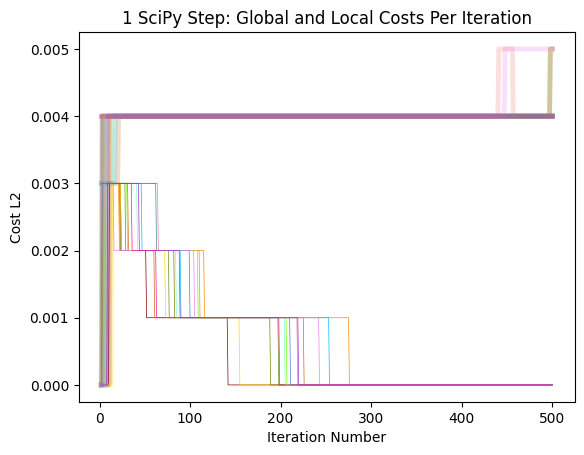

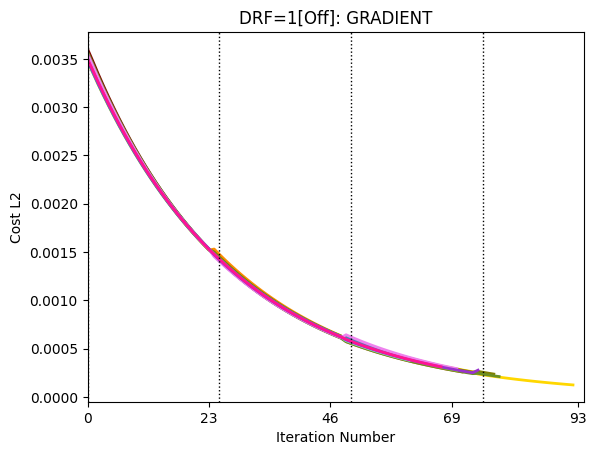

In [18]:
users_c1_1ss = [Client(i, D_0_7, 'EtaScipyMinStep', cond1b1_dict_list[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_c1_1ss = Server(1, D_0_7, 'FedAvg', users_c1_1ss)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_c1_1ss.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_c1_1ss.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(users_c1_1ss, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(global_c1_1ss, 'global', show_update_change=False, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(users_c1_1ss, 'local', dim_reduc_factor=1, plot_gradient=True, local_error=False, global_error=False, custom_title='DRF=1[Off]: GRADIENT')

In [19]:
random.seed(a=27)
#cond2b1_AllInitDecs_list[i]
# Replaced the above since then init dec is 2x64 when all should be 2x7

users_c2_1ss = [Client(i, np.random.rand(2,7), 'EtaScipyMinStep', cond2b1_dict_list[i], 'streaming', condition_number=2, delay_scaling=0) for i in range(14)]
global_c2_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c2_1ss)

users_c3_1ss = [Client(i, np.random.rand(2,7), 'EtaScipyMinStep', cond2b1_dict_list[i], 'streaming', condition_number=3, delay_scaling=0) for i in range(14)]
global_c3_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c3_1ss)

users_c4_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond4b1_dict_list[i], 'streaming', condition_number=4, delay_scaling=0) for i in range(14)]
global_c4_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c4_1ss)

users_c5_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond5b1_dict_list[i], 'streaming', condition_number=5, delay_scaling=0) for i in range(14)]
global_c5_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c5_1ss)

users_c6_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond6b1_dict_list[i], 'streaming', condition_number=6, delay_scaling=0) for i in range(14)]
global_c6_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c6_1ss)

users_c7_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond7b1_dict_list[i], 'streaming', condition_number=7, delay_scaling=0) for i in range(14)]
global_c7_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c7_1ss)

users_c8_1ss = [Client(i, np.random.rand(2,7), 'FullScipyMinStep', cond8b1_dict_list[i], 'streaming', condition_number=8, delay_scaling=0) for i in range(14)]
global_c8_1ss = Server(-1, np.random.rand(2,7), 'FedAvg', users_c8_1ss)

for i in range(big_loop_iters):
    global_c2_1ss.execute_FL_loop()
    global_c3_1ss.execute_FL_loop()
    global_c4_1ss.execute_FL_loop()
    global_c5_1ss.execute_FL_loop()
    global_c6_1ss.execute_FL_loop()
    global_c7_1ss.execute_FL_loop()
    global_c8_1ss.execute_FL_loop()

In [23]:
t0 = time.time()

users_lst = [users_c1_1ss, users_c2_1ss, users_c3_1ss, users_c4_1ss, users_c5_1ss, users_c6_1ss, users_c7_1ss, users_c8_1ss]
cond_dfs = [pd.DataFrame(columns=['Subject', 'Update Number', 'Flattened Dec']) for _ in range(8)]

for key_idx, key in enumerate(keys):
    #df1.loc[len(dec_flattened1)] = [key, update_number, np.ravel(users_c1_1ss[key_idx].dec_log[update_number])]
    for cond_number in range(8):
        update_number = 10
        for current_iter in range(len(users_lst[cond_number][key_idx].dec_log)):
            if update_number==17:
                # Skip the last update
                # We shouldn't reach this with just 500 iters
                print("LAST UPDATE")
                continue
            elif current_iter!=0 and current_iter%users_lst[cond_number][key_idx].local_round_threshold==0:
                update_number+=1
                if update_number==17:
                    continue
            cond_dfs[cond_number].loc[cond_dfs[cond_number].shape[0]] = [key, update_number, np.ravel(users_lst[cond_number][key_idx].dec_log[current_iter])]

t1 = time.time()
total = t1-t0  
print(total)

11.796605587005615


In [24]:
# Concat all the dfs into a single training input dataframe
dec_flattened_1ss = pd.concat([cond_dfs[0], cond_dfs[1], cond_dfs[2], cond_dfs[3], cond_dfs[4], cond_dfs[5], cond_dfs[6], cond_dfs[7]], ignore_index=True, axis=0)

# Make each ele its own cell
expanded_dec_df_1ss = dec_flattened_1ss.join(dec_flattened_1ss['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
print(expanded_dec_df_1ss.shape)
expanded_dec_df_1ss.head()

(8112, 16)


,Subject,Update Number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,METACPHS_S106,10,0.419424,0.215853,0.465258,0.190166,0.237313,0.904313,0.271112,0.477171,0.674054,0.038332,0.877896,0.346810,0.110869,0.513160
1,METACPHS_S106,10,0.400822,0.205012,0.445304,0.182126,0.227144,0.865815,0.259715,0.455093,0.645273,0.036735,0.840548,0.332059,0.106113,0.491273
2,METACPHS_S106,10,0.386871,0.196880,0.430339,0.176096,0.219518,0.836942,0.251167,0.438535,0.623687,0.035537,0.812537,0.320996,0.102547,0.474858
3,METACPHS_S106,10,0.372611,0.188551,0.414978,0.169906,0.211689,0.807303,0.242392,0.421610,0.601575,0.034308,0.783783,0.309639,0.098886,0.458007
4,METACPHS_S106,10,0.359068,0.180630,0.400354,0.164014,0.204236,0.779086,0.234038,0.405537,0.580548,0.033138,0.756410,0.298827,0.095400,0.441965


In [25]:
max_update = np.max(expanded_dec_df_1ss['Update Number'])
print(max_update)

13


In [26]:
expanded_dec_df_1ss.tail()

,Subject,Update Number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
8107,METACPHS_S119,12,0.176645,0.048179,-0.081545,-0.052937,-0.000039,0.001963,-0.004133,0.164839,-0.025519,-0.006752,-0.036386,0.010095,-0.000900,0.000053
8108,METACPHS_S119,12,0.176660,0.048148,-0.081534,-0.052906,-0.000048,0.001961,-0.004136,0.164799,-0.025545,-0.006759,-0.036371,0.010090,-0.000898,0.000054
8109,METACPHS_S119,12,0.176649,0.048171,-0.081542,-0.052929,-0.000041,0.001962,-0.004133,0.164829,-0.025526,-0.006753,-0.036383,0.010094,-0.000899,0.000053
8110,METACPHS_S119,12,0.176657,0.048154,-0.081536,-0.052912,-0.000046,0.001961,-0.004135,0.164807,-0.025540,-0.006757,-0.036374,0.010091,-0.000898,0.000054
8111,METACPHS_S119,13,0.097749,-0.089173,-0.008949,-0.028877,-0.004058,0.003588,0.006778,0.035234,0.017461,-0.006013,-0.014043,0.005906,-0.000604,0.007769


In [27]:
print(set(expanded_dec_df_1ss.isnull().sum(axis=1)))

{0}


In [51]:
present_updates = expanded_dec_df_1ss['Update Number'].unique()
print(present_updates)

[10 11 12 13]


In [52]:
non_nth_update_idxs = expanded_dec_df_1ss[~(expanded_dec_df_1ss['Update Number'] == present_updates[0])].index
non_nth_update_idxs

Int64Index([  25,   26,   27,   28,   29,   30,   31,   32,   33,   34,
            ...
            8102, 8103, 8104, 8105, 8106, 8107, 8108, 8109, 8110, 8111],
           dtype='int64', length=5312)

In [34]:
full_test_df_1ss = make_all_update_models(expanded_dec_df_1ss, n_start_stop=(present_updates[0], present_updates[-1]), stratification=True)
full_test_df_1ss.head()

Round i=10 of stop=13
10
{10, 11, 12, 13}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=11 of stop=13
11
{10, 11, 12, 13}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=12 of stop=13
12
{10, 11, 12, 13}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)


Round i=13 of stop=13
13
{10, 11, 12, 13}



C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\kcs_ml_infr.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_df.drop(['Subject', 'Update Number'], axis=1, inplace=True)
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kdmen\miniconda3\lib\site-pa

,Algorithm,Test Acc,N
0,LogisticRegression(),40.238,10
0,KNeighborsClassifier(),80.714,10
0,GaussianNB(),20.357,10
0,LinearSVC(),40.357,10
0,SGDClassifier(),38.81,10
0,DecisionTreeClassifier(),75.595,10
0,GradientBoostingClassifier(),76.071,10
0,LogisticRegression(),40.476,11


In [41]:
lr_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='LogisticRegression()']
knn_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='KNeighborsClassifier()']
svc_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='LinearSVC()']
sgd_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='SGDClassifier()']
dt_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='DecisionTreeClassifier()']
gbt_df_1ss = full_test_df_1ss[full_test_df_1ss['Algorithm']=='GradientBoostingClassifier()']

In [53]:
lr_df_1ss.head()

,Algorithm,Test Acc,N
0,LogisticRegression(),40.238,10
0,LogisticRegression(),40.476,11
0,LogisticRegression(),24.571,12
0,LogisticRegression(),24.074,13


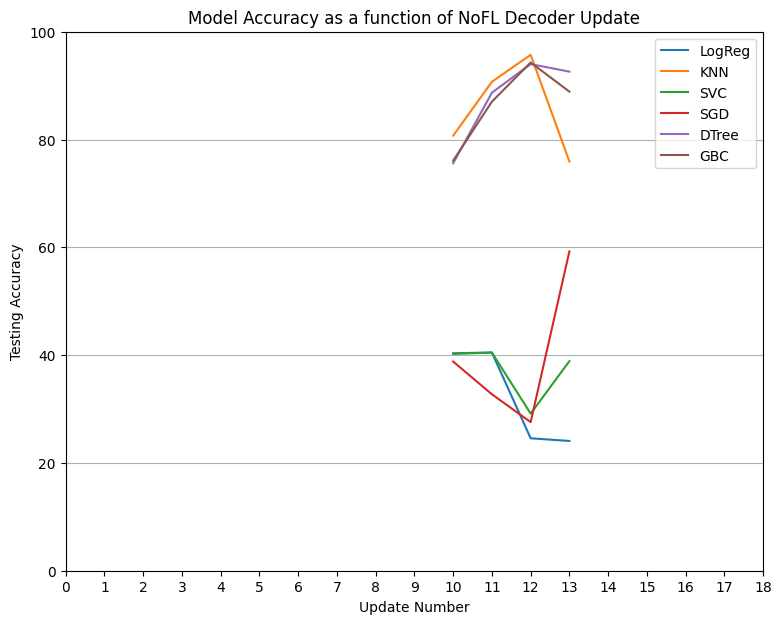

In [47]:
col_num = 1  # Test Acc column
my_x_updates = list(range(present_updates[0], present_updates[-1]+1))

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df_1ss.iloc[:, col_num], label='LogReg')
plt.plot(my_x_updates, knn_df_1ss.iloc[:, col_num], label='KNN')
plt.plot(my_x_updates, svc_df_1ss.iloc[:, col_num], label='SVC')
plt.plot(my_x_updates, sgd_df_1ss.iloc[:, col_num], label='SGD')
plt.plot(my_x_updates, dt_df_1ss.iloc[:, col_num], label='DTree')
plt.plot(my_x_updates, gbt_df_1ss.iloc[:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()

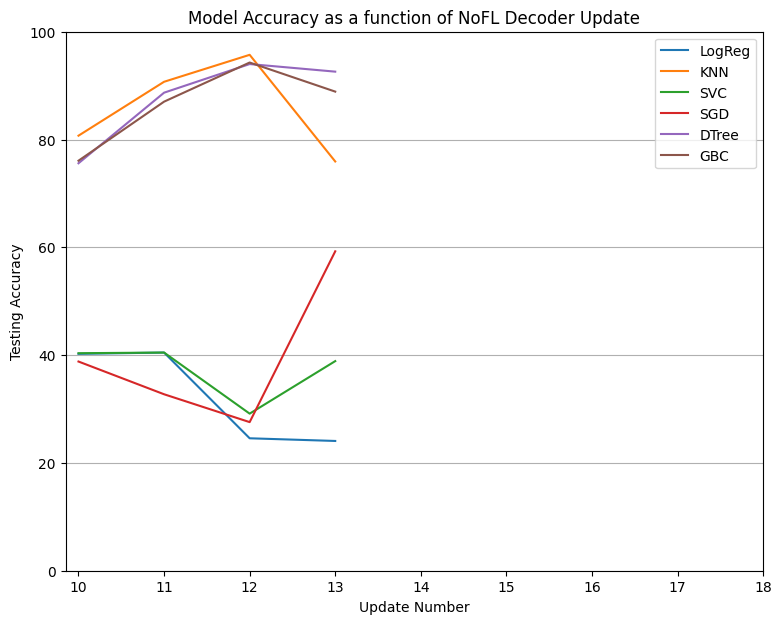

In [48]:
col_num = 1  # Test Acc column
my_x_updates = list(range(present_updates[0], present_updates[-1]+1))

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df_1ss.iloc[:, col_num], label='LogReg')
plt.plot(my_x_updates, knn_df_1ss.iloc[:, col_num], label='KNN')
plt.plot(my_x_updates, svc_df_1ss.iloc[:, col_num], label='SVC')
plt.plot(my_x_updates, sgd_df_1ss.iloc[:, col_num], label='SGD')
plt.plot(my_x_updates, dt_df_1ss.iloc[:, col_num], label='DTree')
plt.plot(my_x_updates, gbt_df_1ss.iloc[:, col_num], label='GBC')
plt.xticks(np.arange(present_updates[0], 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of NoFL Decoder Update')
plt.legend(loc='best')
plt.show()